# Fine-Tuning BERT to Understand Semantic Textual Relatedness

Justin Liu

## Fine-tuning the models

**Reference:** [Training a SentenceTransformers model](https://www.sbert.net/docs/training/overview.html)

In [1]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

from tqdm import tqdm
import random
import logging
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sentence_transformers import LoggingHandler, SentenceTransformer, models, InputExample, losses
from sentence_transformers.evaluation import SimilarityFunction, EmbeddingSimilarityEvaluator

import torch
from torch.utils.data import DataLoader

In [2]:
# outputs info (e.g., loss) when training a model
logging.basicConfig(format="%(asctime)s - %(message)s", 
                    datefmt="%Y-%m-%d %H:%M:%S", 
                    level=logging.INFO, 
                    handlers=[LoggingHandler()])

In [3]:
# load the data
df = pd.read_csv("data/eng_train.csv")
df[["sentence_1", "sentence_2"]] = df["Text"].str.split("\n", n=1, expand=True)
df = df[["sentence_1", "sentence_2", "Score"]]
df

,sentence_1,sentence_2,Score
0,"It that happens, just pull the plug.","if that ever happens, just pull the plug.",1.0
1,A black dog running through water.,A black dog is running through some water.,1.0
2,I've been searchingthe entire abbey for you.,I'm looking for you all over the abbey.,1.0
3,If he is good looking and has a good personali...,"If he's good looking, and a good personality, ...",1.0
4,"She does not hate you, she is just annoyed wit...","She doesn't hate you, she is just annoyed.",1.0
...,...,...,...
5495,A young boy pounding on an anvil.,Woman sits on the curb talking on a cellphone.,0.0
5496,I love how he recognized his wife tempered his...,"Torpedo Ink is Viktor's Band of Brothers, the ...",0.0
5497,I actually read a chapter or two beyond that p...,Lets say she's a blend of two types of beings.,0.0
5498,A boy gives being in the snow two thumbs up.,A satisfied cat is perched beside a crystal lamp.,0.0


In [4]:
# create 80-20 split in the data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=1)

**Loading the model**

- The model can either of the following:
  - A specific model for sentence similarity (`pretrained=True`, e.g., [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2))
  - A general embedding model (`pretrained=False`, e.g., [BERT](https://huggingface.co/bert-base-uncased)) or 

In [5]:
def load_model(model_name, pretrained, seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if pretrained:
        model = SentenceTransformer(model_name)
    
    else:
        word_embedding_model = models.Transformer(model_name)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
        model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
    
    return model

**Preparing the data**

- For each row, we convert it to an `InputExample`
  - Example: `InputExample(texts=["Here is the first sentence", "Here is the second sentence"], label=0.8)`
- We then append each of these to a list
  - Example: `[InputExample(texts=..., label=...), ..., [InputExample(texts=..., label=...)]`
- We do this separately for the training and test data

In [6]:
def prepare_data(df):
    data = []

    for i in range(len(df)):
        sentence_1 = df["sentence_1"].iloc[i]
        sentence_2 = df["sentence_2"].iloc[i]
        label = float(df["Score"].iloc[i])

        datapoint = InputExample(texts=[sentence_1, sentence_2], label=label)
        data.append(datapoint)
    
    return data

**Training the model**

- [Source code for `EmbeddingSimilarityEvaluator`](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py)
- Only the test loss (not the training loss) is returned after each epoch

In [7]:
def train_model(model_name, pretrained, train_df=train_df, test_df=test_df, epochs=10, batch_size=8):
    # load the model
    model = load_model(model_name, pretrained)

    # prepare the data (dataframes -> list of InputExamples)
    train_data = prepare_data(train_df)
    test_data = prepare_data(test_df)
    
    # define the training data, loss function, and test data
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    train_loss = losses.CosineSimilarityLoss(model)
    evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_data, name="test", main_similarity=SimilarityFunction.COSINE)

    # evaluate the model before training
    corr_before_training = evaluator(model)

    # train the model
    start = time.time()
    model.fit(train_objectives=[(train_dataloader, train_loss)], 
              evaluator=evaluator, 
              epochs=epochs, 
              output_path=f"models/{model_name}")
    end = time.time()

    # evaluate the model after training
    corr_after_training = evaluator(model)

    # print info about the model
    print()
    print(f"Training time: {end - start} seconds")
    print(f"Spearman's correlation before training: {corr_before_training}")
    print(f"Spearman's correlation after training: {corr_after_training}")

### Fine-tuning a pretrained sentence similarity model

- **[MiniLM](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2):** model pretrained on sentence similarity tasks (for comparison with the BERT models)

In [ ]:
train_model("all-MiniLM-L6-v2", pretrained=True)

2024-01-18 16:48:18 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2024-01-18 16:48:19 - Use pytorch device: cpu
2024-01-18 16:48:19 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-18 16:48:31 - Cosine-Similarity :	Pearson: 0.8242	Spearman: 0.8204
2024-01-18 16:48:31 - Manhattan-Distance:	Pearson: 0.8231	Spearman: 0.8198
2024-01-18 16:48:31 - Euclidean-Distance:	Pearson: 0.8235	Spearman: 0.8204
2024-01-18 16:48:31 - Dot-Product-Similarity:	Pearson: 0.8242	Spearman: 0.8204


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 16:51:57 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 0:
2024-01-18 16:52:09 - Cosine-Similarity :	Pearson: 0.8287	Spearman: 0.8258
2024-01-18 16:52:09 - Manhattan-Distance:	Pearson: 0.8280	Spearman: 0.8250
2024-01-18 16:52:09 - Euclidean-Distance:	Pearson: 0.8282	Spearman: 0.8258
2024-01-18 16:52:09 - Dot-Product-Similarity:	Pearson: 0.8287	Spearman: 0.8258
2024-01-18 16:52:09 - Save model to models/all-MiniLM-L6-v2


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 16:55:41 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 1:
2024-01-18 16:55:54 - Cosine-Similarity :	Pearson: 0.8371	Spearman: 0.8343
2024-01-18 16:55:54 - Manhattan-Distance:	Pearson: 0.8345	Spearman: 0.8331
2024-01-18 16:55:54 - Euclidean-Distance:	Pearson: 0.8349	Spearman: 0.8343
2024-01-18 16:55:54 - Dot-Product-Similarity:	Pearson: 0.8371	Spearman: 0.8343
2024-01-18 16:55:54 - Save model to models/all-MiniLM-L6-v2


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 16:59:26 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 2:
2024-01-18 16:59:38 - Cosine-Similarity :	Pearson: 0.8441	Spearman: 0.8413
2024-01-18 16:59:38 - Manhattan-Distance:	Pearson: 0.8397	Spearman: 0.8400
2024-01-18 16:59:38 - Euclidean-Distance:	Pearson: 0.8404	Spearman: 0.8413
2024-01-18 16:59:38 - Dot-Product-Similarity:	Pearson: 0.8441	Spearman: 0.8413
2024-01-18 16:59:38 - Save model to models/all-MiniLM-L6-v2


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:03:27 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 3:
2024-01-18 17:03:41 - Cosine-Similarity :	Pearson: 0.8483	Spearman: 0.8456
2024-01-18 17:03:41 - Manhattan-Distance:	Pearson: 0.8429	Spearman: 0.8437
2024-01-18 17:03:41 - Euclidean-Distance:	Pearson: 0.8439	Spearman: 0.8456
2024-01-18 17:03:41 - Dot-Product-Similarity:	Pearson: 0.8483	Spearman: 0.8456
2024-01-18 17:03:41 - Save model to models/all-MiniLM-L6-v2


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:07:33 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 4:
2024-01-18 17:07:45 - Cosine-Similarity :	Pearson: 0.8518	Spearman: 0.8491
2024-01-18 17:07:45 - Manhattan-Distance:	Pearson: 0.8459	Spearman: 0.8473
2024-01-18 17:07:45 - Euclidean-Distance:	Pearson: 0.8469	Spearman: 0.8491
2024-01-18 17:07:45 - Dot-Product-Similarity:	Pearson: 0.8518	Spearman: 0.8491
2024-01-18 17:07:45 - Save model to models/all-MiniLM-L6-v2


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:11:27 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 5:
2024-01-18 17:11:40 - Cosine-Similarity :	Pearson: 0.8547	Spearman: 0.8519
2024-01-18 17:11:40 - Manhattan-Distance:	Pearson: 0.8478	Spearman: 0.8493
2024-01-18 17:11:40 - Euclidean-Distance:	Pearson: 0.8491	Spearman: 0.8519
2024-01-18 17:11:40 - Dot-Product-Similarity:	Pearson: 0.8547	Spearman: 0.8519
2024-01-18 17:11:40 - Save model to models/all-MiniLM-L6-v2


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:15:46 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 6:
2024-01-18 17:16:00 - Cosine-Similarity :	Pearson: 0.8540	Spearman: 0.8515
2024-01-18 17:16:00 - Manhattan-Distance:	Pearson: 0.8482	Spearman: 0.8491
2024-01-18 17:16:00 - Euclidean-Distance:	Pearson: 0.8495	Spearman: 0.8515
2024-01-18 17:16:00 - Dot-Product-Similarity:	Pearson: 0.8540	Spearman: 0.8515


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:19:57 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 7:
2024-01-18 17:20:11 - Cosine-Similarity :	Pearson: 0.8563	Spearman: 0.8542
2024-01-18 17:20:11 - Manhattan-Distance:	Pearson: 0.8505	Spearman: 0.8517
2024-01-18 17:20:11 - Euclidean-Distance:	Pearson: 0.8517	Spearman: 0.8542
2024-01-18 17:20:11 - Dot-Product-Similarity:	Pearson: 0.8563	Spearman: 0.8542
2024-01-18 17:20:11 - Save model to models/all-MiniLM-L6-v2


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:24:10 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 8:
2024-01-18 17:24:24 - Cosine-Similarity :	Pearson: 0.8544	Spearman: 0.8518
2024-01-18 17:24:24 - Manhattan-Distance:	Pearson: 0.8487	Spearman: 0.8492
2024-01-18 17:24:24 - Euclidean-Distance:	Pearson: 0.8497	Spearman: 0.8518
2024-01-18 17:24:24 - Dot-Product-Similarity:	Pearson: 0.8544	Spearman: 0.8518


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:28:17 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 9:
2024-01-18 17:28:31 - Cosine-Similarity :	Pearson: 0.8520	Spearman: 0.8489
2024-01-18 17:28:31 - Manhattan-Distance:	Pearson: 0.8462	Spearman: 0.8461
2024-01-18 17:28:31 - Euclidean-Distance:	Pearson: 0.8474	Spearman: 0.8489
2024-01-18 17:28:31 - Dot-Product-Similarity:	Pearson: 0.8520	Spearman: 0.8489
2024-01-18 17:28:31 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-18 17:28:45 - Cosine-Similarity :	Pearson: 0.8520	Spearman: 0.8489
2024-01-18 17:28:45 - Manhattan-Distance:	Pearson: 0.8462	Spearman: 0.8461
2024-01-18 17:28:45 - Euclidean-Distance:	Pearson: 0.8474	Spearman: 0.8489
2024-01-18 17:28:45 - Dot-Product-Similarity:	Pearson: 0.8520	Spearman: 0.8489

Training time: 2400.645197868347 seconds
Spearman's correlation before training: 0.8204069050504272
Spearman's correlation after training: 0.8489106059257141


### Fine-tuning BERT models that were *not* pretrained on sentence similarity tasks

- **[BERT](https://huggingface.co/bert-base-uncased):** model that gives contextual embeddings

In [ ]:
train_model("bert-base-uncased", pretrained=False)

2024-01-18 19:54:05 - Use pytorch device: cpu
2024-01-18 19:54:05 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-18 19:55:40 - Cosine-Similarity :	Pearson: 0.5988	Spearman: 0.5862
2024-01-18 19:55:40 - Manhattan-Distance:	Pearson: 0.6016	Spearman: 0.5778
2024-01-18 19:55:40 - Euclidean-Distance:	Pearson: 0.6014	Spearman: 0.5768
2024-01-18 19:55:40 - Dot-Product-Similarity:	Pearson: 0.4077	Spearman: 0.4381


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 20:23:42 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 0:
2024-01-18 20:25:05 - Cosine-Similarity :	Pearson: 0.7154	Spearman: 0.7122
2024-01-18 20:25:05 - Manhattan-Distance:	Pearson: 0.6486	Spearman: 0.6355
2024-01-18 20:25:05 - Euclidean-Distance:	Pearson: 0.6491	Spearman: 0.6360
2024-01-18 20:25:05 - Dot-Product-Similarity:	Pearson: 0.5789	Spearman: 0.6058
2024-01-18 20:25:05 - Save model to models/bert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 20:48:40 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 1:
2024-01-18 20:49:58 - Cosine-Similarity :	Pearson: 0.7816	Spearman: 0.7810
2024-01-18 20:49:58 - Manhattan-Distance:	Pearson: 0.7069	Spearman: 0.6967
2024-01-18 20:49:58 - Euclidean-Distance:	Pearson: 0.7086	Spearman: 0.6986
2024-01-18 20:49:58 - Dot-Product-Similarity:	Pearson: 0.6853	Spearman: 0.7107
2024-01-18 20:49:58 - Save model to models/bert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 21:13:57 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 2:
2024-01-18 21:15:11 - Cosine-Similarity :	Pearson: 0.8146	Spearman: 0.8135
2024-01-18 21:15:11 - Manhattan-Distance:	Pearson: 0.7595	Spearman: 0.7519
2024-01-18 21:15:11 - Euclidean-Distance:	Pearson: 0.7615	Spearman: 0.7536
2024-01-18 21:15:11 - Dot-Product-Similarity:	Pearson: 0.7323	Spearman: 0.7496
2024-01-18 21:15:11 - Save model to models/bert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 21:39:34 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 3:
2024-01-18 21:40:48 - Cosine-Similarity :	Pearson: 0.8278	Spearman: 0.8246
2024-01-18 21:40:48 - Manhattan-Distance:	Pearson: 0.7833	Spearman: 0.7759
2024-01-18 21:40:48 - Euclidean-Distance:	Pearson: 0.7851	Spearman: 0.7774
2024-01-18 21:40:48 - Dot-Product-Similarity:	Pearson: 0.7631	Spearman: 0.7708
2024-01-18 21:40:48 - Save model to models/bert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 22:03:13 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 4:
2024-01-18 22:04:27 - Cosine-Similarity :	Pearson: 0.8331	Spearman: 0.8280
2024-01-18 22:04:27 - Manhattan-Distance:	Pearson: 0.7877	Spearman: 0.7767
2024-01-18 22:04:27 - Euclidean-Distance:	Pearson: 0.7894	Spearman: 0.7781
2024-01-18 22:04:27 - Dot-Product-Similarity:	Pearson: 0.7752	Spearman: 0.7788
2024-01-18 22:04:27 - Save model to models/bert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 22:42:34 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 5:
2024-01-18 22:44:46 - Cosine-Similarity :	Pearson: 0.8325	Spearman: 0.8266
2024-01-18 22:44:46 - Manhattan-Distance:	Pearson: 0.7913	Spearman: 0.7800
2024-01-18 22:44:46 - Euclidean-Distance:	Pearson: 0.7927	Spearman: 0.7812
2024-01-18 22:44:46 - Dot-Product-Similarity:	Pearson: 0.7765	Spearman: 0.7763


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 23:16:43 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 6:
2024-01-18 23:18:04 - Cosine-Similarity :	Pearson: 0.8311	Spearman: 0.8247
2024-01-18 23:18:04 - Manhattan-Distance:	Pearson: 0.7871	Spearman: 0.7754
2024-01-18 23:18:04 - Euclidean-Distance:	Pearson: 0.7890	Spearman: 0.7770
2024-01-18 23:18:04 - Dot-Product-Similarity:	Pearson: 0.7694	Spearman: 0.7712


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 23:45:49 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 7:
2024-01-18 23:47:15 - Cosine-Similarity :	Pearson: 0.8343	Spearman: 0.8281
2024-01-18 23:47:15 - Manhattan-Distance:	Pearson: 0.7966	Spearman: 0.7840
2024-01-18 23:47:15 - Euclidean-Distance:	Pearson: 0.7978	Spearman: 0.7854
2024-01-18 23:47:15 - Dot-Product-Similarity:	Pearson: 0.7837	Spearman: 0.7847
2024-01-18 23:47:15 - Save model to models/bert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-19 00:26:46 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 8:
2024-01-19 00:28:35 - Cosine-Similarity :	Pearson: 0.8349	Spearman: 0.8298
2024-01-19 00:28:35 - Manhattan-Distance:	Pearson: 0.7918	Spearman: 0.7782
2024-01-19 00:28:35 - Euclidean-Distance:	Pearson: 0.7929	Spearman: 0.7792
2024-01-19 00:28:35 - Dot-Product-Similarity:	Pearson: 0.7755	Spearman: 0.7801
2024-01-19 00:28:35 - Save model to models/bert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-19 00:56:18 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 9:
2024-01-19 00:57:43 - Cosine-Similarity :	Pearson: 0.8360	Spearman: 0.8316
2024-01-19 00:57:43 - Manhattan-Distance:	Pearson: 0.7955	Spearman: 0.7838
2024-01-19 00:57:43 - Euclidean-Distance:	Pearson: 0.7968	Spearman: 0.7847
2024-01-19 00:57:43 - Dot-Product-Similarity:	Pearson: 0.7651	Spearman: 0.7721
2024-01-19 00:57:43 - Save model to models/bert-base-uncased
2024-01-19 00:57:44 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-19 00:59:14 - Cosine-Similarity :	Pearson: 0.8360	Spearman: 0.8316
2024-01-19 00:59:14 - Manhattan-Distance:	Pearson: 0.7955	Spearman: 0.7838
2024-01-19 00:59:14 - Euclidean-Distance:	Pearson: 0.7968	Spearman: 0.7847
2024-01-19 00:59:14 - Dot-Product-Similarity:	Pearson: 0.7651	Spearman: 0.7721

Training time: 18123.49370574951 seconds
Spearman's correlation before training: 0.5861911648346045
Spearman's correlation after trainin

- **[DistilBERT](https://huggingface.co/distilbert-base-uncased):** smaller version of BERT

In [ ]:
train_model("distilbert-base-uncased", pretrained=False)

2024-01-18 17:28:46 - Use pytorch device: cpu
2024-01-18 17:28:46 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-18 17:29:32 - Cosine-Similarity :	Pearson: 0.6211	Spearman: 0.6212
2024-01-18 17:29:32 - Manhattan-Distance:	Pearson: 0.6048	Spearman: 0.5887
2024-01-18 17:29:32 - Euclidean-Distance:	Pearson: 0.6022	Spearman: 0.5867
2024-01-18 17:29:32 - Dot-Product-Similarity:	Pearson: 0.3993	Spearman: 0.4414


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:41:10 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 0:
2024-01-18 17:41:48 - Cosine-Similarity :	Pearson: 0.7094	Spearman: 0.7107
2024-01-18 17:41:48 - Manhattan-Distance:	Pearson: 0.6754	Spearman: 0.6657
2024-01-18 17:41:48 - Euclidean-Distance:	Pearson: 0.6738	Spearman: 0.6638
2024-01-18 17:41:48 - Dot-Product-Similarity:	Pearson: 0.5716	Spearman: 0.6401
2024-01-18 17:41:48 - Save model to models/distilbert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 17:53:17 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 1:
2024-01-18 17:53:59 - Cosine-Similarity :	Pearson: 0.7638	Spearman: 0.7661
2024-01-18 17:53:59 - Manhattan-Distance:	Pearson: 0.7308	Spearman: 0.7268
2024-01-18 17:53:59 - Euclidean-Distance:	Pearson: 0.7291	Spearman: 0.7251
2024-01-18 17:53:59 - Dot-Product-Similarity:	Pearson: 0.6683	Spearman: 0.7147
2024-01-18 17:53:59 - Save model to models/distilbert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 18:07:21 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 2:
2024-01-18 18:08:08 - Cosine-Similarity :	Pearson: 0.7990	Spearman: 0.7991
2024-01-18 18:08:08 - Manhattan-Distance:	Pearson: 0.7642	Spearman: 0.7583
2024-01-18 18:08:08 - Euclidean-Distance:	Pearson: 0.7634	Spearman: 0.7572
2024-01-18 18:08:08 - Dot-Product-Similarity:	Pearson: 0.7281	Spearman: 0.7526
2024-01-18 18:08:08 - Save model to models/distilbert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 18:20:14 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 3:
2024-01-18 18:20:52 - Cosine-Similarity :	Pearson: 0.8170	Spearman: 0.8162
2024-01-18 18:20:52 - Manhattan-Distance:	Pearson: 0.7832	Spearman: 0.7758
2024-01-18 18:20:52 - Euclidean-Distance:	Pearson: 0.7824	Spearman: 0.7752
2024-01-18 18:20:52 - Dot-Product-Similarity:	Pearson: 0.7525	Spearman: 0.7655
2024-01-18 18:20:52 - Save model to models/distilbert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 18:32:18 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 4:
2024-01-18 18:32:56 - Cosine-Similarity :	Pearson: 0.8236	Spearman: 0.8206
2024-01-18 18:32:56 - Manhattan-Distance:	Pearson: 0.7856	Spearman: 0.7769
2024-01-18 18:32:56 - Euclidean-Distance:	Pearson: 0.7850	Spearman: 0.7763
2024-01-18 18:32:56 - Dot-Product-Similarity:	Pearson: 0.7610	Spearman: 0.7731
2024-01-18 18:32:56 - Save model to models/distilbert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 18:44:49 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 5:
2024-01-18 18:45:31 - Cosine-Similarity :	Pearson: 0.8263	Spearman: 0.8230
2024-01-18 18:45:31 - Manhattan-Distance:	Pearson: 0.7940	Spearman: 0.7853
2024-01-18 18:45:31 - Euclidean-Distance:	Pearson: 0.7931	Spearman: 0.7845
2024-01-18 18:45:31 - Dot-Product-Similarity:	Pearson: 0.7656	Spearman: 0.7755
2024-01-18 18:45:31 - Save model to models/distilbert-base-uncased


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 18:57:41 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 6:
2024-01-18 18:58:18 - Cosine-Similarity :	Pearson: 0.8234	Spearman: 0.8207
2024-01-18 18:58:18 - Manhattan-Distance:	Pearson: 0.7959	Spearman: 0.7868
2024-01-18 18:58:18 - Euclidean-Distance:	Pearson: 0.7949	Spearman: 0.7865
2024-01-18 18:58:18 - Dot-Product-Similarity:	Pearson: 0.7601	Spearman: 0.7713


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 19:18:45 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 7:
2024-01-18 19:19:30 - Cosine-Similarity :	Pearson: 0.8260	Spearman: 0.8223
2024-01-18 19:19:30 - Manhattan-Distance:	Pearson: 0.7918	Spearman: 0.7816
2024-01-18 19:19:30 - Euclidean-Distance:	Pearson: 0.7908	Spearman: 0.7809
2024-01-18 19:19:30 - Dot-Product-Similarity:	Pearson: 0.7616	Spearman: 0.7713


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 19:34:28 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 8:
2024-01-18 19:35:43 - Cosine-Similarity :	Pearson: 0.8212	Spearman: 0.8151
2024-01-18 19:35:43 - Manhattan-Distance:	Pearson: 0.7880	Spearman: 0.7751
2024-01-18 19:35:43 - Euclidean-Distance:	Pearson: 0.7876	Spearman: 0.7752
2024-01-18 19:35:43 - Dot-Product-Similarity:	Pearson: 0.7558	Spearman: 0.7644


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-18 19:52:29 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 9:
2024-01-18 19:53:16 - Cosine-Similarity :	Pearson: 0.8249	Spearman: 0.8209
2024-01-18 19:53:16 - Manhattan-Distance:	Pearson: 0.7902	Spearman: 0.7790
2024-01-18 19:53:16 - Euclidean-Distance:	Pearson: 0.7896	Spearman: 0.7785
2024-01-18 19:53:16 - Dot-Product-Similarity:	Pearson: 0.7595	Spearman: 0.7715
2024-01-18 19:53:16 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-18 19:54:04 - Cosine-Similarity :	Pearson: 0.8249	Spearman: 0.8209
2024-01-18 19:54:04 - Manhattan-Distance:	Pearson: 0.7902	Spearman: 0.7790
2024-01-18 19:54:04 - Euclidean-Distance:	Pearson: 0.7896	Spearman: 0.7785
2024-01-18 19:54:04 - Dot-Product-Similarity:	Pearson: 0.7595	Spearman: 0.7715

Training time: 8624.180510044098 seconds
Spearman's correlation before training: 0.6212475648126776
Spearman's correlation after training: 0.820906534682297


- **[RoBERTa](https://huggingface.co/roberta-base):** BERT model trained on more data and for more time

In [ ]:
train_model("roberta-base", pretrained=False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2024-01-20 10:38:29 - Use pytorch device: cpu
2024-01-20 10:38:29 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-20 10:39:33 - Cosine-Similarity :	Pearson: 0.5473	Spearman: 0.5677
2024-01-20 10:39:33 - Manhattan-Distance:	Pearson: 0.6044	Spearman: 0.5862
2024-01-20 10:39:33 - Euclidean-Distance:	Pearson: 0.5622	Spearman: 0.5508
2024-01-20 10:39:33 - Dot-Product-Similarity:	Pearson: 0.0795	Spearman: 0.0803


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 11:04:13 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 0:
2024-01-20 11:05:27 - Cosine-Similarity :	Pearson: 0.7787	Spearman: 0.7801
2024-01-20 11:05:27 - Manhattan-Distance:	Pearson: 0.7238	Spearman: 0.7182
2024-01-20 11:05:27 - Euclidean-Distance:	Pearson: 0.7244	Spearman: 0.7181
2024-01-20 11:05:27 - Dot-Product-Similarity:	Pearson: 0.6754	Spearman: 0.7146
2024-01-20 11:05:27 - Save model to models/roberta-base


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 11:34:05 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 1:
2024-01-20 11:35:34 - Cosine-Similarity :	Pearson: 0.8152	Spearman: 0.8146
2024-01-20 11:35:34 - Manhattan-Distance:	Pearson: 0.7664	Spearman: 0.7601
2024-01-20 11:35:34 - Euclidean-Distance:	Pearson: 0.7685	Spearman: 0.7622
2024-01-20 11:35:34 - Dot-Product-Similarity:	Pearson: 0.7285	Spearman: 0.7581
2024-01-20 11:35:34 - Save model to models/roberta-base


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 12:01:16 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 2:
2024-01-20 12:02:35 - Cosine-Similarity :	Pearson: 0.8319	Spearman: 0.8305
2024-01-20 12:02:35 - Manhattan-Distance:	Pearson: 0.7930	Spearman: 0.7864
2024-01-20 12:02:35 - Euclidean-Distance:	Pearson: 0.7950	Spearman: 0.7881
2024-01-20 12:02:35 - Dot-Product-Similarity:	Pearson: 0.7525	Spearman: 0.7725
2024-01-20 12:02:35 - Save model to models/roberta-base


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 12:39:05 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 3:
2024-01-20 12:41:01 - Cosine-Similarity :	Pearson: 0.8388	Spearman: 0.8350
2024-01-20 12:41:01 - Manhattan-Distance:	Pearson: 0.7977	Spearman: 0.7886
2024-01-20 12:41:01 - Euclidean-Distance:	Pearson: 0.8003	Spearman: 0.7914
2024-01-20 12:41:01 - Dot-Product-Similarity:	Pearson: 0.7680	Spearman: 0.7846
2024-01-20 12:41:01 - Save model to models/roberta-base


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 13:11:50 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 4:
2024-01-20 13:13:09 - Cosine-Similarity :	Pearson: 0.8367	Spearman: 0.8314
2024-01-20 13:13:09 - Manhattan-Distance:	Pearson: 0.8018	Spearman: 0.7925
2024-01-20 13:13:09 - Euclidean-Distance:	Pearson: 0.8025	Spearman: 0.7930
2024-01-20 13:13:09 - Dot-Product-Similarity:	Pearson: 0.7734	Spearman: 0.7838


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 13:42:01 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 5:
2024-01-20 13:43:24 - Cosine-Similarity :	Pearson: 0.8405	Spearman: 0.8366
2024-01-20 13:43:24 - Manhattan-Distance:	Pearson: 0.8127	Spearman: 0.8062
2024-01-20 13:43:24 - Euclidean-Distance:	Pearson: 0.8132	Spearman: 0.8060
2024-01-20 13:43:24 - Dot-Product-Similarity:	Pearson: 0.7829	Spearman: 0.7919
2024-01-20 13:43:24 - Save model to models/roberta-base


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 14:12:50 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 6:
2024-01-20 14:14:16 - Cosine-Similarity :	Pearson: 0.8392	Spearman: 0.8351
2024-01-20 14:14:16 - Manhattan-Distance:	Pearson: 0.8124	Spearman: 0.8059
2024-01-20 14:14:16 - Euclidean-Distance:	Pearson: 0.8127	Spearman: 0.8055
2024-01-20 14:14:16 - Dot-Product-Similarity:	Pearson: 0.7978	Spearman: 0.8020


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 14:43:27 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 7:
2024-01-20 14:44:50 - Cosine-Similarity :	Pearson: 0.8388	Spearman: 0.8349
2024-01-20 14:44:50 - Manhattan-Distance:	Pearson: 0.8093	Spearman: 0.8020
2024-01-20 14:44:50 - Euclidean-Distance:	Pearson: 0.8092	Spearman: 0.8011
2024-01-20 14:44:50 - Dot-Product-Similarity:	Pearson: 0.7876	Spearman: 0.7924


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 15:13:09 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 8:
2024-01-20 15:14:28 - Cosine-Similarity :	Pearson: 0.8409	Spearman: 0.8358
2024-01-20 15:14:28 - Manhattan-Distance:	Pearson: 0.8130	Spearman: 0.8064
2024-01-20 15:14:28 - Euclidean-Distance:	Pearson: 0.8130	Spearman: 0.8060
2024-01-20 15:14:28 - Dot-Product-Similarity:	Pearson: 0.7930	Spearman: 0.7967


Iteration:   0%|          | 0/550 [00:00<?, ?it/s]

2024-01-20 15:41:50 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset after epoch 9:
2024-01-20 15:43:03 - Cosine-Similarity :	Pearson: 0.8424	Spearman: 0.8351
2024-01-20 15:43:03 - Manhattan-Distance:	Pearson: 0.8058	Spearman: 0.7944
2024-01-20 15:43:03 - Euclidean-Distance:	Pearson: 0.8068	Spearman: 0.7951
2024-01-20 15:43:03 - Dot-Product-Similarity:	Pearson: 0.7738	Spearman: 0.7812
2024-01-20 15:43:03 - EmbeddingSimilarityEvaluator: Evaluating the model on test dataset:
2024-01-20 15:44:21 - Cosine-Similarity :	Pearson: 0.8424	Spearman: 0.8351
2024-01-20 15:44:21 - Manhattan-Distance:	Pearson: 0.8058	Spearman: 0.7944
2024-01-20 15:44:21 - Euclidean-Distance:	Pearson: 0.8068	Spearman: 0.7951
2024-01-20 15:44:21 - Dot-Product-Similarity:	Pearson: 0.7738	Spearman: 0.7812

Training time: 18210.114369630814 seconds
Spearman's correlation before training: 0.5677490280767198
Spearman's correlation after training: 0.8351086350876137


## Plots

### Before fine-tuning

In [8]:
# don't output messages
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [9]:
def cosine_similarity(x, y):
    return dot(x, y) / (norm(x) * norm(y))

def get_similarity_scores(model, df):
    scores = []
    print("Getting the similarity scores for all sentence pairs...")

    for i in tqdm(range(len(df))):
        texts = [df["sentence_1"].iloc[i], df["sentence_2"].iloc[i]]
        x, y = model.encode(texts)
        similarity = cosine_similarity(x, y)
        scores.append(similarity)
    
    return scores

def calculate_errors(predicted_values, actual_values):
    mse = mean_squared_error(predicted_values, actual_values)
    print(f"Mean squared error: {mse:.5f}")

    mae = mean_absolute_error(predicted_values, actual_values)
    print(f"Mean absolute error: {mae:.5f}")
    
    spearman = spearmanr(predicted_values, actual_values)
    corr = spearman.statistic
    p_value = spearman.pvalue
    print(f"Spearman correlation: {corr:.5f} (p-value = {p_value:.5e})")

def plot_scores(predicted_values, actual_values, plot_title):
    plt.scatter(predicted_values, actual_values)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(plot_title)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.plot([-0.1, 1.1], [-0.1, 1.1], "r")

def show_all_results(model, df, actual_values, plot_title):
    predicted_values = get_similarity_scores(model, df)
    calculate_errors(predicted_values, actual_values)
    plot_scores(predicted_values, actual_values, plot_title)

Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [00:17<00:00, 63.72it/s]


Mean squared error: 0.02043
Mean absolute error: 0.11252
Spearman correlation: 0.82041 (p-value = 8.03195e-269)


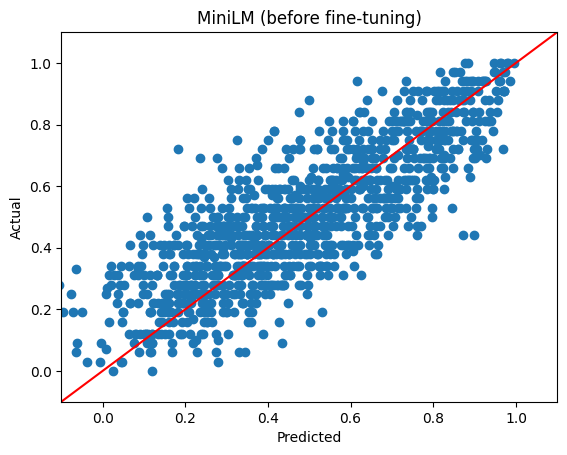

In [10]:
minilm = load_model("all-MiniLM-L6-v2", pretrained=True)
show_all_results(minilm, test_df, test_df["Score"], "MiniLM (before fine-tuning)")

Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [01:36<00:00, 11.38it/s]

Mean squared error: 0.09184
Mean absolute error: 0.25653
Spearman correlation: 0.58619 (p-value = 1.70216e-102)


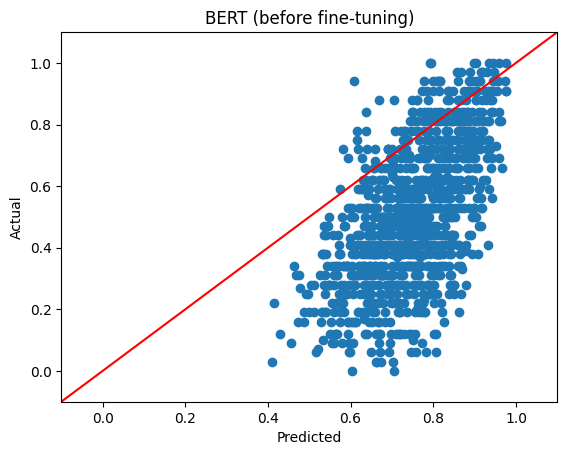

In [11]:
bert = load_model("bert-base-uncased", pretrained=False)
show_all_results(bert, test_df, test_df["Score"], "BERT (before fine-tuning)")

Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [00:47<00:00, 23.30it/s]


Mean squared error: 0.13874
Mean absolute error: 0.32793
Spearman correlation: 0.62125 (p-value = 2.05149e-118)


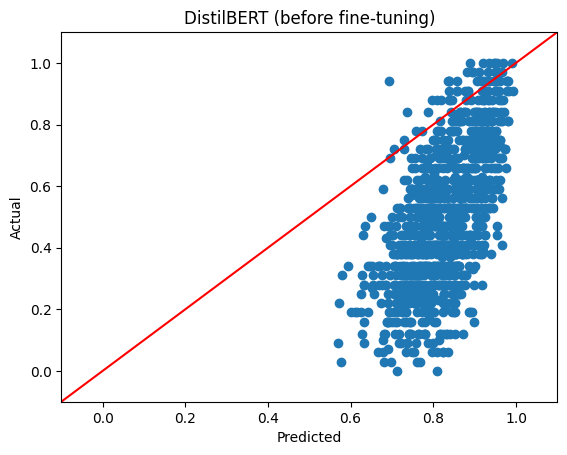

In [12]:
distilbert = load_model("distilbert-base-uncased", pretrained=False)
show_all_results(distilbert, test_df, test_df["Score"], "DistilBERT (before fine-tuning)")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [01:32<00:00, 11.92it/s]


Mean squared error: 0.27248
Mean absolute error: 0.47468
Spearman correlation: 0.56774 (p-value = 7.19631e-95)


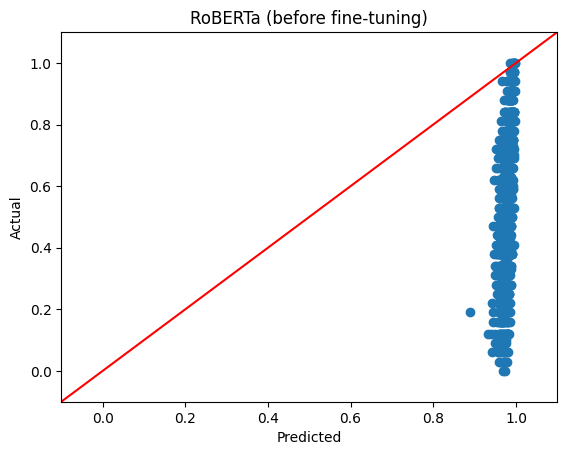

In [13]:
roberta = load_model("roberta-base", pretrained=False)
show_all_results(roberta, test_df, test_df["Score"], "RoBERTa (before fine-tuning)")

### Training progress on the test data

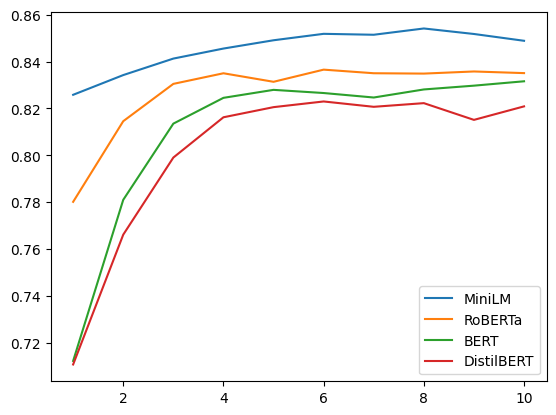

In [14]:
# define range of epochs
epochs = list(range(1, 11))

# read Spearman correlation data from each trained model
minilm_results = pd.read_csv("models/all-MiniLM-L6-v2/eval/similarity_evaluation_test_results.csv")["cosine_spearman"]
roberta_results = pd.read_csv("models/roberta-base/eval/similarity_evaluation_test_results.csv")["cosine_spearman"]
bert_results = pd.read_csv("models/bert-base-uncased/eval/similarity_evaluation_test_results.csv")["cosine_spearman"]
distilbert_results = pd.read_csv("models/distilbert-base-uncased/eval/similarity_evaluation_test_results.csv")["cosine_spearman"]
roberta_results = pd.read_csv("models/roberta-base/eval/similarity_evaluation_test_results.csv")["cosine_spearman"]

# plot progress over epochs
plt.plot(epochs, minilm_results, label="MiniLM")
plt.plot(epochs, roberta_results, label="RoBERTa")
plt.plot(epochs, bert_results, label="BERT")
plt.plot(epochs, distilbert_results, label="DistilBERT")
plt.legend()

### After fine-tuning

Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [00:17<00:00, 62.76it/s]


Mean squared error: 0.01461
Mean absolute error: 0.09795
Spearman correlation: 0.85417 (p-value = 4.17787e-314)


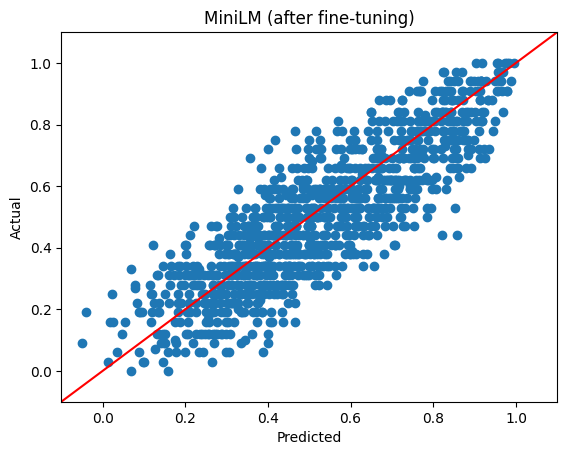

In [15]:
minilm_fine_tuned = load_model("models/all-MiniLM-L6-v2", pretrained=True)
show_all_results(minilm_fine_tuned, test_df, test_df["Score"], "MiniLM (after fine-tuning)")

Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [01:33<00:00, 11.71it/s]

Mean squared error: 0.01671
Mean absolute error: 0.10302
Spearman correlation: 0.83162 (p-value = 9.78719e-283)


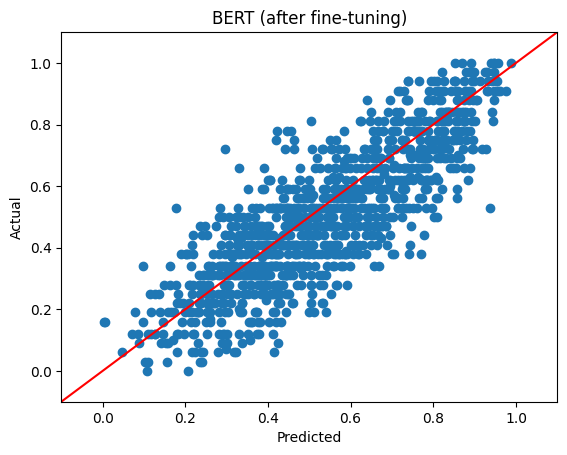

In [16]:
bert_fine_tuned = load_model("models/bert-base-uncased", pretrained=True)
show_all_results(bert_fine_tuned, test_df, test_df["Score"], "BERT (after fine-tuning)")

Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [00:50<00:00, 21.97it/s]


Mean squared error: 0.01710
Mean absolute error: 0.10379
Spearman correlation: 0.82300 (p-value = 5.90648e-272)


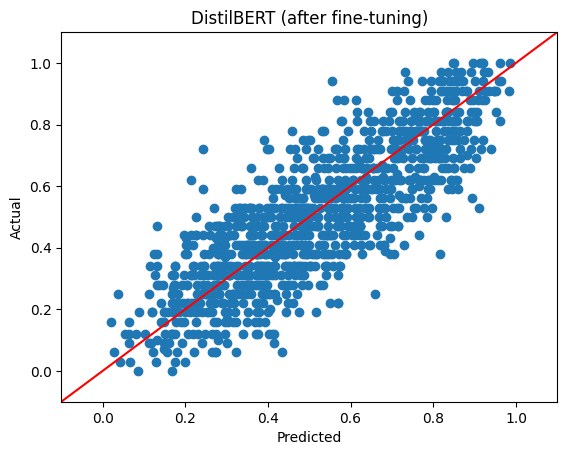

In [17]:
distilbert_fine_tuned = load_model("models/distilbert-base-uncased", pretrained=True)
show_all_results(distilbert_fine_tuned, test_df, test_df["Score"], "DistilBERT (after fine-tuning)")

Getting the similarity scores for all sentence pairs...


100%|██████████| 1100/1100 [01:34<00:00, 11.65it/s]

Mean squared error: 0.01650
Mean absolute error: 0.10154
Spearman correlation: 0.83659 (p-value = 3.10694e-289)


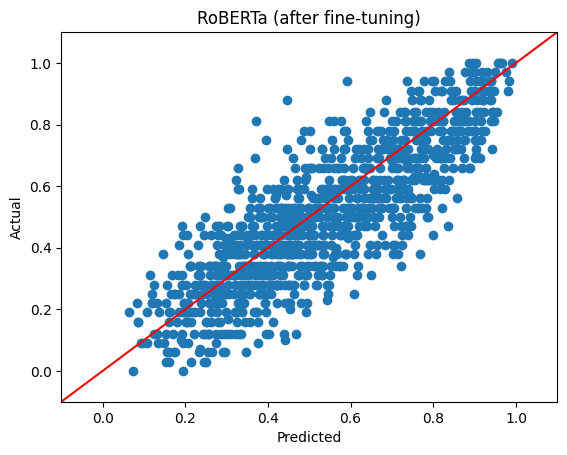

In [18]:
roberta_fine_tuned = load_model("models/roberta-base", pretrained=True)
show_all_results(roberta_fine_tuned, test_df, test_df["Score"], "RoBERTa (after fine-tuning)")